In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

In [246]:
df = pd.read_csv('data/dataset_mood_smartphone.csv')
df = df.drop(df.columns[0], axis=1)
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df = pd.pivot_table(df, values='value', index=['id', 'date'],
                                columns=['variable'], aggfunc=[np.sum, np.mean]).reset_index()
df.head(5)

id        date     mean                                      \
variable                      activity appCat.builtin appCat.communication   
0         AS14.01  2014-02-17      NaN            NaN                  NaN   
1         AS14.01  2014-02-18      NaN            NaN                  NaN   
2         AS14.01  2014-02-19      NaN            NaN                  NaN   
3         AS14.01  2014-02-20      NaN            NaN                  NaN   
4         AS14.01  2014-02-21      NaN            NaN                  NaN   

                                                                        \
variable appCat.entertainment appCat.finance appCat.game appCat.office   
0                         NaN            NaN         NaN           NaN   
1                         NaN            NaN         NaN           NaN   
2                         NaN            NaN         NaN           NaN   
3                         NaN            NaN         NaN           NaN   
4                         NaN            NaN         NaN           NaN   

                       ...                                                \
variable appCat.other  ... appCat.travel appCat.unknown appCat.utilities   
0                 NaN  ...           NaN            NaN              NaN   
1                 NaN  ...           NaN            NaN              NaN   
2                 NaN  ...           NaN            NaN              NaN   
3                 NaN  ...           NaN            NaN              NaN   
4                 NaN  ...           NaN            NaN              NaN   

                                                                         \
variable appCat.weather call circumplex.arousal circumplex.valence mood   
0                   NaN  1.0                NaN                NaN  NaN   
1                   NaN  1.0                NaN                NaN  NaN   
2                   NaN  1.0                NaN                NaN  NaN   
3                   NaN  1.0                NaN                NaN  NaN   
4                   NaN  NaN                NaN                NaN  NaN   

                      
variable screen  sms  
0           NaN  NaN  
1           NaN  NaN  
2           NaN  1.0  
3           NaN  1.0  
4           NaN  1.0  

[5 rows x 21 columns]

In [135]:
def iqr_correction(data):
    """
    Applies iqr outlier detection method to dataframe and 
    replaces the outliers with NaN values
    """

    Q1 = data.value.quantile(0.25)
    Q3 = data.value.quantile(0.75)
    IQR = Q3 - Q1
    lim_width = 1.5
    lower_lim = Q1 - (lim_width*IQR)
    upper_lim = Q3 + (lim_width*IQR)
    corrected = np.where(data.value > upper_lim, np.nan, np.where(data.value < lower_lim, np.nan, data.value))

    return corrected

def outliers_to_nan(df, per_person, variablelist):
    """
    returns dataframe for which outliers are replaced with NaN for each element in
    the variablelist using the iqr method. Values of the variablelist are first 
    transformed to log values to counter the skewness of the distributions.
    """

    new_values = []

    if per_person:
        for person in df.id.unique():
            for var in variablelist:
                df_var = pd.DataFrame(columns=['value'])
                df_var['value'] = np.log(df[(df.variable == var) & (df.id == person)].value.values)
                corrected = iqr_correction(data=df_var, iqr=True, siqr=False)
                new_values.extend(corrected)
    
    for var in df.variable.unique():
        if var in variablelist:
            df_var = pd.DataFrame(columns=['value'])
            df_var['value'] = np.log(df[df.variable == var].value.values)
            corrected = iqr_correction(data=df_var)
            new_values.extend(corrected)
        else:
            new_values.extend(np.log(df[df.variable == var].value.values))

    new_values = np.exp(new_values)
    df['value'] = new_values
    return df



In [176]:
df_new = outliers_to_nan(df=df, per_person=False, variablelist=['screen', 
                                                                     'appCat.builtin', 
                                                                     'appCat.communication', 
                                                                     'appCat.entertainment', 
                                                                     'appCat.finance',
                                                                     'appCat.game', 
                                                                     'appCat.office', 
                                                                     'appCat.other', 
                                                                     'appCat.social', 
                                                                     'appCat.travel', 
                                                                     'appCat.unknown',
                                                                     'appCat.utilities', 
                                                                     'appCat.weather']
)
df_new

,id,time,variable,value,date
0,AS14.01,2014-02-26 13:00:00.000,mood,6.000,2014-02-26
1,AS14.01,2014-02-26 15:00:00.000,mood,6.000,2014-02-26
2,AS14.01,2014-02-26 18:00:00.000,mood,6.000,2014-02-26
3,AS14.01,2014-02-26 21:00:00.000,mood,7.000,2014-02-26
4,AS14.01,2014-02-27 09:00:00.000,mood,6.000,2014-02-27
...,...,...,...,...,...
376907,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032,2014-04-11
376908,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008,2014-04-19
376909,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026,2014-04-26
376910,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033,2014-04-27


In [245]:
df_group = df_new.groupby(['id', 'date', 'variable'])['value'].agg(['sum','mean', 'count']).reset_index()
df_group[df_group.variable == 'mood']

,id,date,variable,sum,mean,count
13,AS14.01,2014-02-26,mood,25.0,6.250000,4
17,AS14.01,2014-02-27,mood,19.0,6.333333,3
60,AS14.01,2014-03-21,mood,31.0,6.200000,5
74,AS14.01,2014-03-22,mood,32.0,6.400000,5
88,AS14.01,2014-03-23,mood,34.0,6.800000,5
...,...,...,...,...,...,...
15474,AS14.33,2014-05-27,mood,31.0,6.200000,5
15488,AS14.33,2014-05-28,mood,41.0,8.200000,5
15502,AS14.33,2014-05-29,mood,21.0,7.000000,3
15517,AS14.33,2014-05-30,mood,34.0,6.800000,5


In [248]:
dfp = df_group.pivot(index=['id', 'date'], columns=['variable'], values=['sum', 'mean', 'count']).reset_index()
dfp

id        date       sum                                      \
variable                       activity appCat.builtin appCat.communication   
0         AS14.01  2014-02-17       NaN            NaN                  NaN   
1         AS14.01  2014-02-18       NaN            NaN                  NaN   
2         AS14.01  2014-02-19       NaN            NaN                  NaN   
3         AS14.01  2014-02-20       NaN            NaN                  NaN   
4         AS14.01  2014-02-21       NaN            NaN                  NaN   
...           ...         ...       ...            ...                  ...   
1968      AS14.33  2014-05-27  0.304902        420.348             2078.403   
1969      AS14.33  2014-05-28  2.479228       2037.432             1936.415   
1970      AS14.33  2014-05-29  4.064507        400.034              435.105   
1971      AS14.33  2014-05-30  4.050925       2295.237             1670.842   
1972      AS14.33  2014-05-31       NaN            NaN                  NaN   

                                                                        \
variable appCat.entertainment appCat.finance appCat.game appCat.office   
0                         NaN            NaN         NaN           NaN   
1                         NaN            NaN         NaN           NaN   
2                         NaN            NaN         NaN           NaN   
3                         NaN            NaN         NaN           NaN   
4                         NaN            NaN         NaN           NaN   
...                       ...            ...         ...           ...   
1968                  124.694            NaN         NaN           NaN   
1969                  614.706            NaN         NaN        76.864   
1970                  136.738            NaN         NaN           NaN   
1971                  260.220            NaN         NaN           NaN   
1972                      NaN            NaN         NaN           NaN   

                       ...         count                                  \
variable appCat.other  ... appCat.travel appCat.unknown appCat.utilities   
0                 NaN  ...           NaN            NaN              NaN   
1                 NaN  ...           NaN            NaN              NaN   
2                 NaN  ...           NaN            NaN              NaN   
3                 NaN  ...           NaN            NaN              NaN   
4                 NaN  ...           NaN            NaN              NaN   
...               ...  ...           ...            ...              ...   
1968           98.282  ...           NaN            NaN              3.0   
1969          243.640  ...           NaN            NaN              6.0   
1970           29.202  ...           1.0            NaN              2.0   
1971           52.610  ...          28.0            3.0             15.0   
1972              NaN  ...           NaN            NaN              NaN   

                                                                          \
variable appCat.weather  call circumplex.arousal circumplex.valence mood   
0                   NaN   2.0                NaN                NaN  NaN   
1                   NaN   1.0                NaN                NaN  NaN   
2                   NaN   7.0                NaN                NaN  NaN   
3                   NaN   2.0                NaN                NaN  NaN   
4                   NaN   NaN                NaN                NaN  NaN   
...                 ...   ...                ...                ...  ...   
1968                NaN   1.0                2.0                4.0  5.0   
1969                NaN  10.0                3.0                5.0  5.0   
1970                NaN   5.0                0.0                3.0  3.0   
1971                NaN   4.0                2.0                2.0  5.0   
1972                NaN   NaN                0.0                1.0  1.0   

                      
variable screen  sms  


In [143]:
from numpy import isnan
from pandas import read_csv
from sklearn.impute import KNNImputer

In [187]:
df_test = df_new[(df_new['id'] == 'AS14.01') & (df_new['variable'] == 'appCat.builtin') & (np.isnan(df_new['value']) == True)]
df_test

,id,time,variable,value,date
143612,AS14.01,2014-03-21 10:31:49.009,appCat.builtin,NaN,2014-03-21
143707,AS14.01,2014-03-21 14:46:18.049,appCat.builtin,NaN,2014-03-21
143743,AS14.01,2014-03-21 19:30:08.579,appCat.builtin,NaN,2014-03-21
143745,AS14.01,2014-03-21 19:34:14.025,appCat.builtin,NaN,2014-03-21
143748,AS14.01,2014-03-21 19:46:12.536,appCat.builtin,NaN,2014-03-21
...,...,...,...,...,...
149525,AS14.01,2014-05-02 10:51:29.341,appCat.builtin,NaN,2014-05-02
149656,AS14.01,2014-05-03 17:02:55.302,appCat.builtin,NaN,2014-05-03
149682,AS14.01,2014-05-04 01:09:41.568,appCat.builtin,NaN,2014-05-04
149715,AS14.01,2014-05-04 12:25:53.062,appCat.builtin,NaN,2014-05-04


In [195]:
df_test.index

Int64Index([143612, 143707, 143743, 143745, 143748, 143762, 143802, 143876,
            143941, 144201, 144237, 144317, 144482, 144554, 144740, 144741,
            144873, 144874, 144934, 144949, 145318, 145321, 145378, 145412,
            145456, 145478, 145862, 145894, 145923, 145939, 146001, 146021,
            146029, 146042, 146063, 146064, 146066, 146070, 146089, 146091,
            146092, 146291, 146407, 146674, 146693, 146766, 146831, 146847,
            146935, 147334, 147646, 147694, 147735, 147738, 147741, 148025,
            148061, 148088, 148154, 148305, 148391, 148473, 148476, 148699,
            148821, 148888, 148889, 148955, 149017, 149027, 149028, 149098,
            149129, 149235, 149373, 149378, 149462, 149525, 149656, 149682,
            149715, 149733],
           dtype='int64')

In [189]:
df_knn = df_new[(df_new['id'] == 'AS14.01') & (df_new['variable'] == 'appCat.builtin')]
df_knn


,id,time,variable,value,date
143507,AS14.01,2014-03-20 22:25:56.111,appCat.builtin,2.288,2014-03-20
143508,AS14.01,2014-03-20 22:34:51.135,appCat.builtin,1.007,2014-03-20
143509,AS14.01,2014-03-20 22:48:30.211,appCat.builtin,37.125,2014-03-20
143510,AS14.01,2014-03-20 22:49:37.628,appCat.builtin,1.003,2014-03-20
143511,AS14.01,2014-03-20 22:50:40.273,appCat.builtin,4.017,2014-03-20
...,...,...,...,...,...
149801,AS14.01,2014-05-05 09:41:34.470,appCat.builtin,6.203,2014-05-05
149802,AS14.01,2014-05-05 09:41:40.795,appCat.builtin,3.423,2014-05-05
149803,AS14.01,2014-05-05 09:41:44.243,appCat.builtin,1.047,2014-05-05
149804,AS14.01,2014-05-05 09:41:45.292,appCat.builtin,12.049,2014-05-05


In [194]:
# df_test = df[(df['variable'] == 'circumplex.arousal') & (df['id'] == 'AS14.01')]
imputer = KNNImputer(n_neighbors=10, weights='uniform', metric='nan_euclidean')
test = imputer.fit_transform(df_knn.value.values.reshape(-1,1))
# Xtrans = imputer.transform([df_test.value.values])
# Xtrans
df_knn['value'] = test.reshape(1,-1)[0]
df_knn

,id,time,variable,value,date
143507,AS14.01,2014-03-20 22:25:56.111,appCat.builtin,2.288,2014-03-20
143508,AS14.01,2014-03-20 22:34:51.135,appCat.builtin,1.007,2014-03-20
143509,AS14.01,2014-03-20 22:48:30.211,appCat.builtin,37.125,2014-03-20
143510,AS14.01,2014-03-20 22:49:37.628,appCat.builtin,1.003,2014-03-20
143511,AS14.01,2014-03-20 22:50:40.273,appCat.builtin,4.017,2014-03-20
...,...,...,...,...,...
149801,AS14.01,2014-05-05 09:41:34.470,appCat.builtin,6.203,2014-05-05
149802,AS14.01,2014-05-05 09:41:40.795,appCat.builtin,3.423,2014-05-05
149803,AS14.01,2014-05-05 09:41:44.243,appCat.builtin,1.047,2014-05-05
149804,AS14.01,2014-05-05 09:41:45.292,appCat.builtin,12.049,2014-05-05


In [196]:
df_lol = df_knn[df_knn.index.isin(df_test.index)]
df_lol

,id,time,variable,value,date
143612,AS14.01,2014-03-21 10:31:49.009,appCat.builtin,6.514399,2014-03-21
143707,AS14.01,2014-03-21 14:46:18.049,appCat.builtin,6.514399,2014-03-21
143743,AS14.01,2014-03-21 19:30:08.579,appCat.builtin,6.514399,2014-03-21
143745,AS14.01,2014-03-21 19:34:14.025,appCat.builtin,6.514399,2014-03-21
143748,AS14.01,2014-03-21 19:46:12.536,appCat.builtin,6.514399,2014-03-21
...,...,...,...,...,...
149525,AS14.01,2014-05-02 10:51:29.341,appCat.builtin,6.514399,2014-05-02
149656,AS14.01,2014-05-03 17:02:55.302,appCat.builtin,6.514399,2014-05-03
149682,AS14.01,2014-05-04 01:09:41.568,appCat.builtin,6.514399,2014-05-04
149715,AS14.01,2014-05-04 12:25:53.062,appCat.builtin,6.514399,2014-05-04


In [170]:
df_test.value.values.reshape(-1,1)

array([[nan],
       [nan],
       [ 0.],
       [ 1.],
       [nan],
       [ 1.],
       [ 1.],
       [nan],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [nan],
       [ 1.],
       [nan],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 2.],
       [ 2.],
       [nan],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [nan],
       [nan],
       [ 0.],
       [ 1.],
       [ 1.],
       [nan],
       [ 1.],
       [ 1.],
       [ 1.],
       [nan],
       [nan],
       [nan],
       [ 0.],
       [nan],
       [ 0.],
       [nan],
       [ 1.],
       [nan],
       [ 0.],
       [ 0.],
       [ 1.],
       [ 0.],
       [ 0.],
       [nan],
       [nan],
       [nan],
       [ 1.],
       [nan],
       [ 0.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 0.],
       [ 0.],
       [nan],
       [ 1.],
       [ 1.],
       [nan],
       [nan],
       [nan],
       [nan],
      

In [156]:
len(Xtrans[0])

124

In [154]:
total = 0
for i in df_test.value.values:
    if np.isnan(i) == True:
        total+=1
total

99

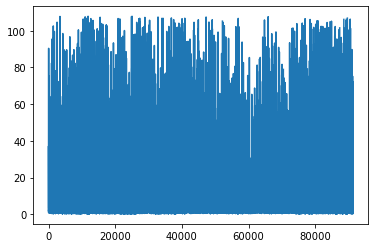

In [120]:
plt.plot(new_values)

In [122]:
total=0
for i in new_values:
    if np.isnan(i) == True:
        total +=1
print(total, len(new_values), len(df[df.variable == 'appCat.builtin'].value.values))

1412 91288 91288


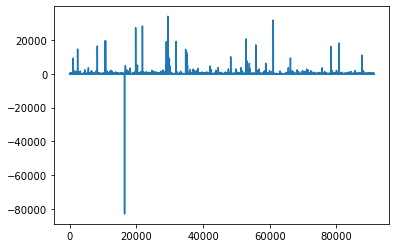

In [121]:
plt.plot(df[df.variable == 'appCat.builtin'].value.values)
plt.show()

<AxesSubplot:ylabel='Count'>

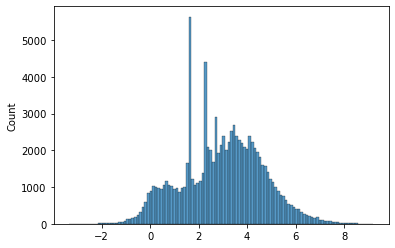

In [90]:
sns.histplot(test)

In [77]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
scaler = StandardScaler()
scaled = scaler.fit_transform(test[:, np.newaxis])
unscaled = scaler.inverse_transform(scaled)
unscaled

array([[ 58.84599996],
       [  9.21700001],
       [ 19.82900023],
       ...,
       [504.01699996],
       [526.13700008],
       [847.77899981]])

<AxesSubplot:ylabel='Count'>

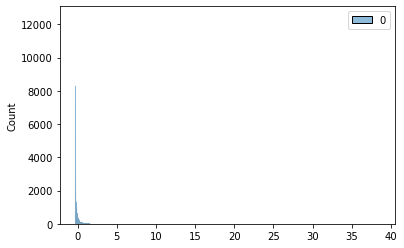

In [78]:
sns.histplot(scaled)

In [73]:
norm = normalize([test])
norm

array([[0.00071518, 0.00011202, 0.00024099, ..., 0.00612555, 0.00639439,
        0.01030345]])

<AxesSubplot:ylabel='Count'>

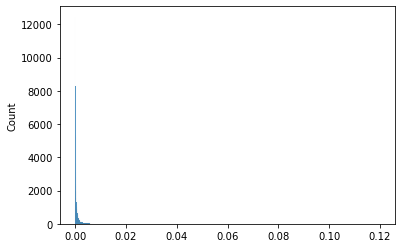

In [74]:
sns.histplot(norm[0])